<a href="https://colab.research.google.com/github/iwolt21/Expected-Goals-Project/blob/main/Assignment3_NeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics
import tensorflow as tf
from sklearn.metrics import r2_score
from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# This code automatically updates your tensorflow to tf 2.
if tf.__version__ < "2.0.0":
  !pip install --upgrade tensorflow_gpu==2.0

In [ ]:
# let me get my data file from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set up data for machine learning - same as asn 1

# Read necessary columns from csv file
columns = ["id", "minute", "result", "X", "Y", "xG", "h_a", "situation", "shotType", "match_id", "lastAction"]
df = pd.read_csv(r"drive/MyDrive/Colab Notebooks/xG Data/FullShotsData.csv", header=0, usecols=columns)

# Do not want to consider own goals in my analysis
df = df[df['result'] != 'OwnGoal']
df = df[df['situation'] != "Penalty"]

idIND = 0
minIND = 1
resIND = 2
XIND = 3
YIND = 4
xGIND = 5
h_aIND = 6
situationIND = 7
shotTypeIND = 8
matchIND = 9
lastActIND = 10

npGoalsX = []
npGoalsY = []
npNonGoalsX = []
npNonGoalsY = []
situationStats = [[[], [], [], []], [0, 0, 0, 0]]
shotTypeStats = [[[], [], [], []], [0, 0, 0, 0]]

# Arrange additional data for visualizing
for data in df.values:
  # Goals data - track goals scored
  if data[resIND] == "Goal":
    npGoalsX.append(data[XIND])
    npGoalsY.append(data[YIND])

  # Missed/Saved/Blocked shots
  else:
    npNonGoalsX.append(data[XIND])
    npNonGoalsY.append(data[YIND])

  # Consider Situations, form data for visualizing
  if data[situationIND] == "OpenPlay":
    situationStats[0][0].append(data[xGIND])
    situationStats[1][0] += 1
  elif data[situationIND] == "DirectFreekick":
    situationStats[0][1].append(data[xGIND])
    situationStats[1][1] += 1
  elif data[situationIND] == "FromCorner":
    situationStats[0][2].append(data[xGIND])
    situationStats[1][2] += 1
  elif data[situationIND] == "SetPiece":
    situationStats[0][3].append(data[xGIND])
    situationStats[1][3] += 1

  # Consider Shot Types, form data for visualizing
  if data[shotTypeIND] == "RightFoot":
    shotTypeStats[0][0].append(data[xGIND])
    shotTypeStats[1][0] += 1
  elif data[shotTypeIND] == "LeftFoot":
    shotTypeStats[0][1].append(data[xGIND])
    shotTypeStats[1][1] += 1
  elif data[shotTypeIND] == "Head":
    shotTypeStats[0][2].append(data[xGIND])
    shotTypeStats[1][2] += 1
  elif data[shotTypeIND] == "OtherBodyPart":
    shotTypeStats[0][3].append(data[xGIND])
    shotTypeStats[1][3] += 1


def section_mapping(value):
    for key, sect in sections.items():
        if value >= key:
            return sect


sections = {
    0.8: "wide",
    0.6: "channel",
    0.4: "middle",
    0.2: "channel",
    -0.1: "wide"
}

# Make Y coordinate into sections on field
df['Y_sects'] = pd.Categorical(df["Y"].map(section_mapping), categories=set(sections.values()), ordered=True)

# Non penalty, predictor is xG, set up X
y = df['xG']
X = df.drop(['id', 'minute', 'result', 'Y', 'xG', 'h_a', 'match_id', 'lastAction'], axis=1)

X = pd.get_dummies(data=X, drop_first=True)
print(X.shape)
print(X.columns)


(287612, 9)
Index(['X', 'situation_FromCorner', 'situation_OpenPlay', 'situation_SetPiece',
       'shotType_LeftFoot', 'shotType_OtherBodyPart', 'shotType_RightFoot',
       'Y_sects_channel', 'Y_sects_wide'],
      dtype='object')


In [ ]:
def get_stats(model, x_train, x_test, y_train, y_test):
  Ypred = model.predict(x_test).flatten()
  print("The mean absolute error on the test set with was", round(metrics.mean_absolute_error(y_test, Ypred), 4))

  # Calculate the R-Squared value for a regression model
  print("The R-Squared value for this model is:", r2_score(y_test, Ypred))

  get_residual_plot(y_test, Ypred)
  return Ypred

def get_residual_plot(y_t, y_p):
  # Create a residual plot
  residuals = y_t - y_p
  plt.scatter(y_p, residuals, alpha=0.5)
  plt.xlabel('Predicted values')
  plt.ylabel('Residuals')
  plt.title('Residual plot')
  plt.show()

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim(0,0.1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.legend()
  plt.show()

Epoch 1/10
6472/6472 [==============================] - 19s 3ms/step - loss: 0.0956 - val_loss: 0.0604
Epoch 2/10
6472/6472 [==============================] - 12s 2ms/step - loss: 0.0600 - val_loss: 0.0597
Epoch 3/10
6472/6472 [==============================] - 13s 2ms/step - loss: 0.0599 - val_loss: 0.0599
Epoch 4/10
6472/6472 [==============================] - 12s 2ms/step - loss: 0.0599 - val_loss: 0.0601
Epoch 5/10
6472/6472 [==============================] - 13s 2ms/step - loss: 0.0599 - val_loss: 0.0596
Epoch 6/10
6472/6472 [==============================] - 13s 2ms/step - loss: 0.0599 - val_loss: 0.0596
Epoch 7/10
6472/6472 [==============================] - 13s 2ms/step - loss: 0.0599 - val_loss: 0.0596
Epoch 8/10
6472/6472 [==============================] - 14s 2ms/step - loss: 0.0599 - val_loss: 0.0597
Epoch 9/10
6472/6472 [==============================] - 15s 2ms/step - loss: 0.0599 - val_loss: 0.0597
Epoch 10/10
6472/6472 [==============================] - 13s 2ms/step - l

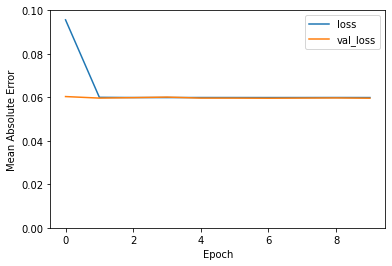

899/899 [==============================] - 1s 1ms/step - loss: 0.0593
0.05931966006755829
Epoch 1/10
6472/6472 [==============================] - 17s 2ms/step - loss: 0.0555 - val_loss: 0.0517
Epoch 2/10
6472/6472 [==============================] - 15s 2ms/step - loss: 0.0512 - val_loss: 0.0513
Epoch 3/10
6472/6472 [==============================] - 15s 2ms/step - loss: 0.0507 - val_loss: 0.0504
Epoch 4/10
6472/6472 [==============================] - 17s 3ms/step - loss: 0.0504 - val_loss: 0.0506
Epoch 5/10
6472/6472 [==============================] - 15s 2ms/step - loss: 0.0500 - val_loss: 0.0484
Epoch 6/10
6472/6472 [==============================] - 16s 2ms/step - loss: 0.0498 - val_loss: 0.0512
Epoch 7/10
6472/6472 [==============================] - 16s 2ms/step - loss: 0.0498 - val_loss: 0.0482
Epoch 8/10
6472/6472 [==============================] - 16s 2ms/step - loss: 0.0497 - val_loss: 0.0502
Epoch 9/10
6472/6472 [==============================] - 15s 2ms/step - loss: 0.0496 - 

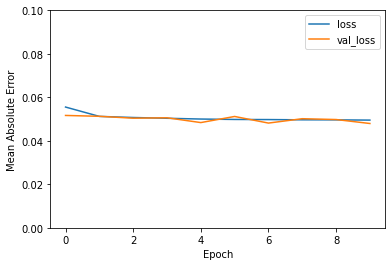

899/899 [==============================] - 1s 1ms/step - loss: 0.0473
0.04734236001968384


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Linear Regression Neural Network
linregNN = tf.keras.Sequential([
    layers.Flatten(input_shape=(9,)),
    tf.keras.layers.Dense(1)
])

# Compile the model
linregNN.compile(optimizer='adam', loss='mean_absolute_error')

history = linregNN.fit(X_train, Y_train, epochs=10, validation_split = 0.2)
plot_loss(history)

print(linregNN.evaluate(X_test, Y_test))


# Deep Neural Network
DNN = tf.keras.Sequential([
    layers.Flatten(input_shape=(9,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

# compile the model
DNN.compile(optimizer='adam', loss='mean_absolute_error')

history = DNN.fit(X_train, Y_train, epochs=10, validation_split = 0.2)
plot_loss(history)

print(DNN.evaluate(X_test, Y_test))

899/899 [==============================] - 1s 1ms/step
The mean absolute error on the test set with was 0.0593
The R-Squared value for this model is: 0.13179602469480645


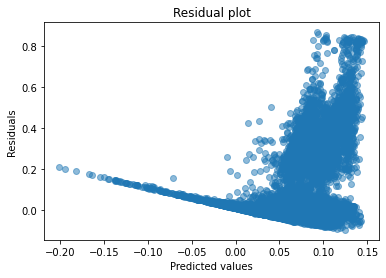

899/899 [==============================] - 2s 2ms/step
The mean absolute error on the test set with was 0.0473
The R-Squared value for this model is: 0.5122845117269916


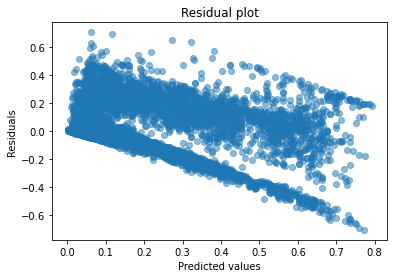

In [ ]:
Y_pred = get_stats(linregNN, X_train, X_test, Y_train, Y_test)
Y_pred = get_stats(DNN, X_train, X_test, Y_train, Y_test)

Epoch 1/10
6472/6472 [==============================] - 16s 2ms/step - loss: 0.0765 - val_loss: 0.0618
Epoch 2/10
6472/6472 [==============================] - 15s 2ms/step - loss: 0.0589 - val_loss: 0.0554
Epoch 3/10
6472/6472 [==============================] - 16s 2ms/step - loss: 0.0560 - val_loss: 0.0541
Epoch 4/10
6472/6472 [==============================] - 15s 2ms/step - loss: 0.0542 - val_loss: 0.0527
Epoch 5/10
6472/6472 [==============================] - 15s 2ms/step - loss: 0.0527 - val_loss: 0.0515
Epoch 6/10
6472/6472 [==============================] - 15s 2ms/step - loss: 0.0515 - val_loss: 0.0502
Epoch 7/10
6472/6472 [==============================] - 16s 2ms/step - loss: 0.0509 - val_loss: 0.0500
Epoch 8/10
6472/6472 [==============================] - 15s 2ms/step - loss: 0.0505 - val_loss: 0.0504
Epoch 9/10
6472/6472 [==============================] - 16s 2ms/step - loss: 0.0504 - val_loss: 0.0504
Epoch 10/10
6472/6472 [==============================] - 15s 2ms/step - l

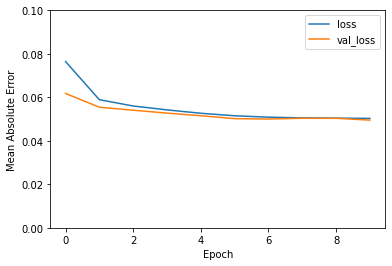

899/899 [==============================] - 1s 1ms/step - loss: 0.0489
0.04888392984867096
899/899 [==============================] - 1s 2ms/step
The mean absolute error on the test set with was 0.0489
The R-Squared value for this model is: 0.49655213829292033


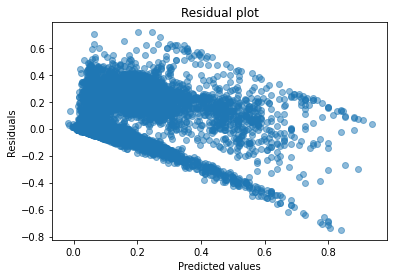

array([0.09769525, 0.04004531, 0.02345891, ..., 0.04834051, 0.04462717,
       0.02245519], dtype=float32)

In [ ]:
# Deep Neural Network
log = tf.keras.Sequential([
    layers.Flatten(input_shape=(9,)),
    layers.Dense(64, activation='sigmoid'),
    layers.Dense(64, activation='sigmoid'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

# compile the model
log.compile(optimizer='adam', loss='mean_absolute_error')

history = log.fit(X_train, Y_train, epochs=10, validation_split = 0.2)
plot_loss(history)

print(log.evaluate(X_test, Y_test))

get_stats(log, X_train, X_test, Y_train, Y_test)

Epoch 1/10
6472/6472 [==============================] - 31s 5ms/step - loss: 0.0531 - val_loss: 0.0491
Epoch 2/10
6472/6472 [==============================] - 28s 4ms/step - loss: 0.0494 - val_loss: 0.0490
Epoch 3/10
6472/6472 [==============================] - 29s 4ms/step - loss: 0.0489 - val_loss: 0.0481
Epoch 4/10
6472/6472 [==============================] - 29s 4ms/step - loss: 0.0485 - val_loss: 0.0481
Epoch 5/10
6472/6472 [==============================] - 29s 5ms/step - loss: 0.0484 - val_loss: 0.0485
Epoch 6/10
6472/6472 [==============================] - 30s 5ms/step - loss: 0.0483 - val_loss: 0.0478
Epoch 7/10
6472/6472 [==============================] - 29s 4ms/step - loss: 0.0482 - val_loss: 0.0488
Epoch 8/10
6472/6472 [==============================] - 28s 4ms/step - loss: 0.0481 - val_loss: 0.0488
Epoch 9/10
6472/6472 [==============================] - 30s 5ms/step - loss: 0.0479 - val_loss: 0.0481
Epoch 10/10
6472/6472 [==============================] - 28s 4ms/step - l

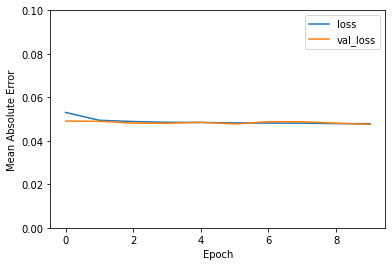

899/899 [==============================] - 3s 3ms/step - loss: 0.0472
0.047151435166597366
899/899 [==============================] - 2s 2ms/step
The mean absolute error on the test set with was 0.0472
The R-Squared value for this model is: 0.5032294355031097


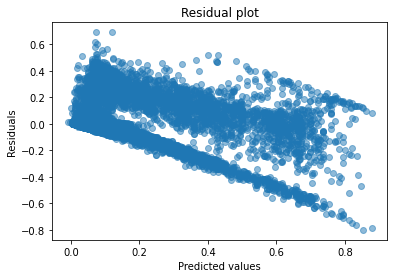

array([0.07830566, 0.05187327, 0.01944585, ..., 0.06319159, 0.05924238,
       0.0263275 ], dtype=float32)

In [ ]:
x_np = np.array(X)
x_3d = x_np.reshape(x_np.shape[0], x_np.shape[1], 1)
X_3d_train, X_3d_test, Y_3d_train, Y_3d_test = train_test_split(x_3d, y, test_size=0.1, random_state=1)

# Create the convolutional neural network
conv = tf.keras.Sequential()
conv.add(layers.Conv1D(32, 2, activation='relu', input_shape=(9,1)))
conv.add(layers.Conv1D(64, 2, activation='relu'))
conv.add(layers.Flatten())
conv.add(layers.Dense(128, activation='relu'))
conv.add(layers.Dense(1))

# compile the model
conv.compile(optimizer='adam', loss='mean_absolute_error')

history = conv.fit(X_3d_train, Y_3d_train, epochs=10, validation_split = 0.2)
plot_loss(history)

print(conv.evaluate(X_test, Y_test))

get_stats(conv, X_3d_train, X_3d_test, Y_3d_train, Y_3d_test)

Epoch 1/20
3641/3641 [==============================] - 17s 4ms/step - loss: 0.0545 - val_loss: 0.0540
Epoch 2/20
3641/3641 [==============================] - 16s 4ms/step - loss: 0.0506 - val_loss: 0.0491
Epoch 3/20
3641/3641 [==============================] - 16s 4ms/step - loss: 0.0499 - val_loss: 0.0493
Epoch 4/20
3641/3641 [==============================] - 16s 4ms/step - loss: 0.0498 - val_loss: 0.0539
Epoch 5/20
3641/3641 [==============================] - 16s 4ms/step - loss: 0.0494 - val_loss: 0.0488
Epoch 6/20
3641/3641 [==============================] - 16s 4ms/step - loss: 0.0494 - val_loss: 0.0491
Epoch 7/20
3641/3641 [==============================] - 16s 4ms/step - loss: 0.0492 - val_loss: 0.0497
Epoch 8/20
3641/3641 [==============================] - 16s 4ms/step - loss: 0.0491 - val_loss: 0.0488
Epoch 9/20
3641/3641 [==============================] - 16s 4ms/step - loss: 0.0491 - val_loss: 0.0491
Epoch 10/20
3641/3641 [==============================] - 16s 4ms/step - l

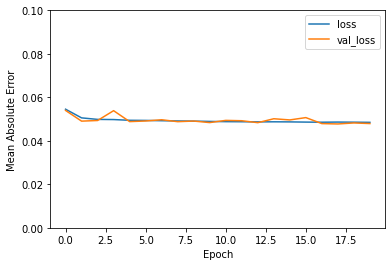

899/899 [==============================] - 1s 2ms/step
The mean absolute error on the test set with was 0.0472
The R-Squared value for this model is: 0.495280018490486


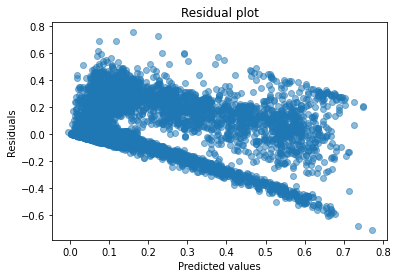

In [ ]:
# Deep Neural Network with experimentation - 20 epoches, 64 batch size, layer size, etc.
DNNextra = tf.keras.Sequential([
    layers.Flatten(input_shape=(9,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

# compile the model
DNNextra.compile(optimizer='adam', loss='mean_absolute_error')

history = DNNextra.fit(X_train, Y_train, epochs=20, batch_size=64, validation_split = 0.1)
plot_loss(history)

Y_pred = get_stats(DNNextra, X_train, X_test, Y_train, Y_test)

# Conclusion

Comparing these neural networks to the previous machine learning models from assignment 1, there is not a significant increase in performance with the neural networks. The best performing model from assignment 1 was the polynomial regression with six dimension and a degree of three. That model had a mean absolute error of 0.0574 and an R-Squared value of 0.5471, along with a reasonably normal distribution for the residual plot. Many of the different variations of the neural network had similar performance, with a mean absolute error of aproximately 0.0475 and an R-Squared value of 0.5, along with a reasonablely normal distribution for the residual plots.

Neural networks are great for unstructured data, such as images and text. They also require a large amount of data to be effective. Neither of these situations occur with our problem, as our data set isn't large enough to benefit a lot from a neural network, and the data is very simple to interpret. So, while the neural networks were able to learn the relationships and predict an accurate xG value, it wasn't much more effective than simple supervised machine learning models such as the polynomial regression and logistic regression models that performed the best in assignment 1.